In [1]:
from DataLoader import *
from Visualization import *
from EstimateFundamentalMatrix import *
from EssentialMatrixFromFundamentalMatrix import *
from GetInliersRANSAC import *
import os

# Don't generate pyc codes
sys.dont_write_bytecode = True

In [2]:
dataDirPath = os.getcwd() + '/P3Data/'
images = loadImages(dataDirPath)
# displayImages(images, 5)


In [3]:
K = getCameraParams(dataDirPath)
print(K)

[[531.12215532   0.         407.19255084]
 [  0.         531.5417375  313.30871505]
 [  0.           0.           1.        ]]


In [4]:
featureMatchesList = parseMatchFiles(dataDirPath)

In [41]:
InlierList, OutlierList = ransac(featureMatchesList[0].matchPairs, 2000, 0.05)
matchPairsInliers = [featureMatchesList[0].matchPairs[i] for i in InlierList]
matchPairsOutliers = [featureMatchesList[0].matchPairs[i] for i in OutlierList]


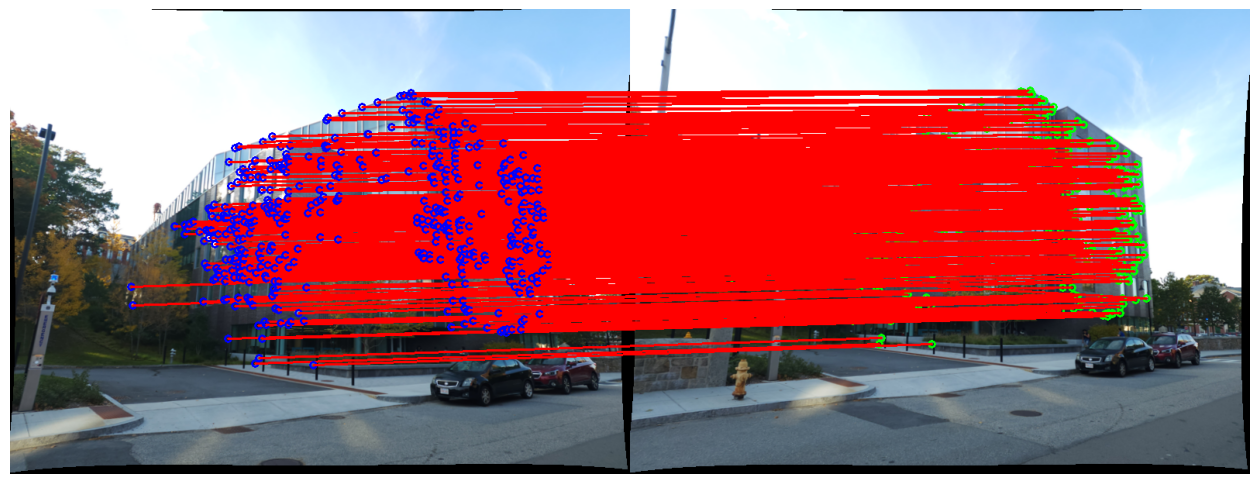

In [42]:
matchImage = drawMatchs(images[0], images[1], matchPairsInliers)

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage)
plt.show()